# AI Project - Phase 2 (Destination Suggestion)
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi, Javad Hezareh, Payam Taebi, Alireza Sakhaei, Ali Banayeean, Yalda Shabanzadeh, Hamidreza Yaghoubi, Alireza Heidari <h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase2.ipynb or .zip </h5>
</div>

## Overview

<div style="text-align: center">
<img src="./Images/Uber_research.jpg" width="100%" height="auto" />
</div>

Suppose you are a research engineer at Uber and you are asked to design a system that suggests destinations to the passengers. The system should be able to suggest destinations based on the passenger's history. For example, one passenger may save a variety of locations (like home, work, gym, etc.). This passenger may go to gym, often on weekends and when he/she requests a car from Home. 

So, for example, if I am a student, going to university usually from Saturday to Wednesday on 8:00 from "home", the next time I request a car from "home" on 8:00, the system should suggest "university" as the destination. Now, it's not that simple always, so we should seek for smart wayys to solve this problem!

As you may understood by now, we should engineer some of features from the data we have and try to predict the next destination of the passenger.

Let's begin!

## Setup

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

from keplergl import KeplerGl

random.seed(2024)
np.random.seed(2024)

C:\Users\Mobilee\AppData\Local\Programs\Python\Python38\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# First Approach: Using KNN

## Data Preparation for KNN

In this part, you should prepare the data for KNN. You should load the dataset file that we provided, named `Data/output.json` and then clean it, do all the required preprocessings and then split into train-test-val sets if necessary. Note that we provided a splitted test set for you, named `Data/output_test.json`. You should not use this file for training or validation. You should only use it for testing your model.

### Load the Dataset

In [3]:
df = pd.read_json('Data/output.json')
df.head(5)

,user_id,Day,origin lat,origin lon,dest lat,dest lon,start_time,end_time,price
0,0,0,35.625,51.375,36.000,51.085,2024-01-30 13:07:00,2024-01-30 14:43:00,43.99
1,0,0,36.000,51.085,35.625,51.375,2024-01-30 15:13:00,2024-01-30 16:49:00,36.66
2,0,0,35.680,51.445,35.745,51.465,2024-01-30 20:41:00,2024-01-30 20:54:00,15.08
3,0,0,35.745,51.465,35.680,51.445,2024-01-30 21:24:00,2024-01-30 21:37:00,10.00
4,0,1,35.625,51.375,35.680,51.445,2024-01-30 23:38:00,2024-01-30 23:58:00,19.48


In [4]:
df_test = pd.read_json('Data/output_test.json')
df_test.head(5)

,user_id,Day,origin lat,origin lon,dest lat,dest lon,start_time,end_time,price
0,24,6,35.650,51.225,35.640,51.270,2024-01-30 11:58:00,2024-01-30 12:12:00,10.00
1,46,2,35.625,51.250,35.690,51.295,2024-01-30 21:58:00,2024-01-30 22:18:00,11.84
2,27,5,35.650,51.225,35.865,51.045,2024-01-30 20:05:00,2024-01-30 20:58:00,23.36
3,7,4,35.875,51.375,35.890,51.315,2024-01-30 17:39:00,2024-01-30 18:17:00,13.74
4,27,3,35.625,51.375,35.650,51.385,2024-01-30 13:16:00,2024-01-30 13:19:00,15.08


### Preprocessing

#### missing values

In [5]:
""" Handling missing Values """
df.isnull().sum()

user_id       0
Day           0
origin lat    0
origin lon    0
dest lat      0
dest lon      0
start_time    0
end_time      0
price         0
dtype: int64

#### feature engineering

In [6]:
def feature_engineering(df):
    # time features
    df['hour_of_start'] = df['start_time'].dt.hour
    df['day_of_start'] = df['start_time'].dt.day
    df['trip_duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60

    # origin loc features
    # df[['origin_label', 'origin_coordinate']] = pd.DataFrame(df['origin'].tolist(), index=df.index)
    # df[['origin_lat', 'origin_lon']] = pd.DataFrame(df['origin_coordinate'].tolist(), index=df.index)

    # destination loc features
    # df[['destination_label', 'destination_coordinate']] = pd.DataFrame(df['destination'].tolist(), index=df.index)
    # df[['destination_lat', 'destination_lon']] = pd.DataFrame(df['destination_coordinate'].tolist(), index=df.index)

    return df

In [7]:
df = feature_engineering(df)
df_test = feature_engineering(df_test)
df

,user_id,Day,origin lat,origin lon,dest lat,dest lon,start_time,end_time,price,hour_of_start,day_of_start,trip_duration
0,0,0,35.625,51.375,36.000,51.085,2024-01-30 13:07:00,2024-01-30 14:43:00,43.99,13,30,96.0
1,0,0,36.000,51.085,35.625,51.375,2024-01-30 15:13:00,2024-01-30 16:49:00,36.66,15,30,96.0
2,0,0,35.680,51.445,35.745,51.465,2024-01-30 20:41:00,2024-01-30 20:54:00,15.08,20,30,13.0
3,0,0,35.745,51.465,35.680,51.445,2024-01-30 21:24:00,2024-01-30 21:37:00,10.00,21,30,13.0
4,0,1,35.625,51.375,35.680,51.445,2024-01-30 23:38:00,2024-01-30 23:58:00,19.48,23,30,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17989,59,0,35.950,51.225,35.875,51.125,2024-01-30 06:41:00,2024-01-30 07:07:00,10.92,6,30,26.0
17990,59,0,35.875,51.125,35.690,51.295,2024-01-30 12:46:00,2024-01-30 13:35:00,17.35,12,30,49.0
17991,59,0,35.875,51.125,35.525,51.100,2024-01-30 17:39:00,2024-01-30 18:48:00,34.56,17,30,69.0
17992,59,0,35.525,51.100,35.815,51.320,2024-01-30 20:09:00,2024-01-30 21:19:00,36.80,20,30,70.0


In [8]:
# print out the number of unique users and also randomly select one user
print("number of unique users:", df['user_id'].nunique())
selected_user = random.choice(df['user_id'].unique())
print("randomly selected user:", selected_user)

number of unique users: 60
randomly selected user: 30


In [9]:
# Extract data for the selected user
user_data = df[df['user_id'] == selected_user]

# Extract destinations from user_data as lat-long pairs
destinations = user_data[['dest lat', 'dest lon']]
destinations.columns = ['latitude', 'longitude']

# Visualize the destinations
map_1 = KeplerGl(height=500)
map_1.add_data(data=destinations, name='destinations')
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'destinations': {'index': [8883, 8884, 8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 88…

Here, you should do feature engineering stuff! Extract the features that you think are important. Split the features into training set and also extract the related outputs (used for our model further). These outputs may be strings (name of destination) or destination's latitude/longitude or etc. Use your creativity!

In [10]:
def categorical_to_numerical(df):
    # One-hot encode 'origin_label'
    onehot_encoder = OneHotEncoder()
    onehot_encoded = onehot_encoder.fit_transform(df[['origin_label']]).toarray()

    # Drop the original 'origin_label' column and add the new one-hot encoded columns
    df = df.drop('origin_label', axis=1)
    df[onehot_encoder.get_feature_names_out(['origin_label'])] = onehot_encoded

    return df

In [11]:
X = df[['user_id', 'Day', 'hour_of_start', 'day_of_start', 'trip_duration', 'origin lat', 'origin lon', 'price']]
# X = categorical_to_numerical(X)
y = df[['dest lat', 'dest lon']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_test = df_test[['user_id', 'Day', 'hour_of_start', 'day_of_start', 'trip_duration', 'origin lat', 'origin lon', 'price']]
# X_test = categorical_to_numerical(X_test)
y_test = df_test[['dest lat', 'dest lon']]

In [12]:
X_train

,user_id,Day,hour_of_start,day_of_start,trip_duration,origin lat,origin lon,price
9523,32,4,6,30,28.0,35.725,51.300,21.27
10784,36,4,7,30,22.0,35.735,51.200,16.41
221,0,5,16,30,42.0,35.520,51.285,27.34
11535,38,3,7,30,13.0,35.710,51.090,17.50
10793,36,1,12,30,25.0,35.625,51.125,18.60
...,...,...,...,...,...,...,...,...
16567,55,2,12,30,40.0,35.625,51.250,22.13
2494,9,4,7,30,5.0,35.615,51.175,13.85
14875,50,6,12,30,49.0,35.975,51.250,24.80
2688,9,3,12,30,18.0,35.625,51.125,10.74


In [13]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (14395, 8)
y_train shape: (14395, 2)
X_val shape: (3599, 8)
y_val shape: (3599, 2)
X_test shape: (4499, 8)
y_test shape: (4499, 2)


## KNN Model

In this section, we are going to implement our KNN model. For further information on how KNN works, please refer to [this](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) link. As you can see, it's a simple algorithm. We will start with this and see the results of our _destination suggestion_ system.

In [14]:
class NearestNeighbor():
    def __init__(self, k=3):
        self.k = k
        self.train_X = None
        self.train_y = None

    def fit(self, train_X, train_y):
        self.train_X = train_X
        self.train_y = train_y

    def predict(self, x):
        predictions = []
        for i in range(x.shape[0]):
            distances = self.calculate_distances(x.iloc[i, :])
            k_nearest_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.train_y.iloc[k_nearest_indices]
            average_label = np.mean(k_nearest_labels, axis=0)
            predictions.append(average_label)
        return pd.DataFrame(predictions, columns=self.train_y.columns)

    def calculate_distances(self, x):
        distances = np.sqrt(np.sum((self.train_X - x) ** 2, axis=1))
        return distances

In [15]:
def calculate_accuracy(y_true, y_pred, tolerance=0):
    correct_predictions = 0
    total_predictions = y_true.shape[0]

    for true, pred in zip(y_true.values, y_pred.values):
        lat_correct = abs(true[0] - pred[0]) <= tolerance
        lon_correct = abs(true[1] - pred[1]) <= tolerance
        if lat_correct and lon_correct:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [16]:
# Fit the model on training data
knn_model = NearestNeighbor(k=1)
knn_model.fit(X_train, y_train)

In [17]:
train_predictions_KNN = knn_model.predict(X_train)
train_accuracy_KNN = calculate_accuracy(y_train, train_predictions_KNN)
print(f"Training Accuracy: {train_accuracy_KNN*100}")

Training Accuracy: 99.98610628690517


In [18]:
val_predictions_KNN = knn_model.predict(X_val)
val_accuracy_KNN = calculate_accuracy(y_val, val_predictions_KNN)
print(f"Validation Accuracy: {val_accuracy_KNN*100}")

Validation Accuracy: 37.14920811336482


In [19]:
test_predictions_KNN = knn_model.predict(X_test)
test_accuracy_KNN = calculate_accuracy(y_test, test_predictions_KNN)
print(f"Test Accuracy: {test_accuracy_KNN*100}")

Test Accuracy: 38.986441431429206


**QUESTION**: What do you think about this approach? Is it a good idea to use KNN for this problem? Why (or why not)? If the patterns in our datatset (passengers' history) get more complicated, will our model be robust to it in comparison to other models?

Your Answer:

***

***While KNN can be a good starting point due to its simplicity, the current results suggest it might not be the best choice for this particular problem, especially as the complexity of the data increases. Exploring more complex models and refining the feature engineering process could lead to better generalization and improved performance on unseen data.***


***

# Second Approach: Using XGBoost

In this part, we are going to use XGBoost to predict the next destination of the passenger. You can use `xgboost` library to implement this model. To learn more about XGBoost, please refer to [this](https://en.wikipedia.org/wiki/XGBoost) link. It should be familiar to you, as you saw decision trees in the class.

For this part, you can use the same data (that you did all the processes on) from the previous part. Or, if you need, you can reload the dataset and do new preprocessings on it.

You can see the overview of how XGBoost works in the image below:

<dev style="text-align: center">
<img src="./Images/XGBoost.png" />
</dev>

Although, this is for more information and you **do not** need to implement `XGBoost` from scratch. You can use the library that we mentioned above.

In [20]:
class Encoder:
    def __init__(self):
      self.trans_dic={}
      self.invtrans_dic={}
      self.j=0

    def fit(self, y):
      y2 = y.to_numpy()
      for i in range(len(y2)):
        if (y2[i][0] , y2[i][1]) not in self.trans_dic:
          self.trans_dic[(y2[i][0] , y2[i][1])]= self.j
          self.invtrans_dic[self.j]= y2[i]
          self.j+=1
      return self.transform(y2)

    def transform(self, y):
      ny= []
      for i in range(len(y)):
        ny.append(self.trans_dic[(y[i][0] , y[i][1])])
      return ny

    def inverse_transform(self, enc):
      ny= []
      for i in range(len(enc)):
        ny.append(self.invtrans_dic[enc[i]])

      return np.array(ny)

In [21]:
def predict_XG(encoder, classifier, X):
      X = X.to_numpy()
      X = np.array(X, dtype=np.float64)
      prediction = classifier.predict(X)
      return encoder.inverse_transform(prediction)

In [22]:
classifier = xgb.XGBClassifier(objective='multi:softmax')
enc = Encoder()

y_train_XG = enc.fit(y_train)
X_train_XG = X_train.to_numpy()
X_train_XG = np.array(X_train_XG,dtype=np.float64)

classifier.fit(X_train_XG, y_train_XG)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [26]:
train_predictions_XGB = predict_XG(encoder=enc, classifier=classifier, X=X_train)
train_accuracy_XGB = calculate_accuracy(y_train, pd.DataFrame(train_predictions_XGB))
print(f"Training Accuracy: {train_accuracy_XGB*100}")

Training Accuracy: 99.97915943035777


In [28]:
val_predictions_XGB = predict_XG(encoder=enc, classifier=classifier, X=X_val)
val_accuracy_XGB = calculate_accuracy(y_val, pd.DataFrame(val_predictions_XGB))
print(f"Validation Accuracy: {val_accuracy_XGB*100}")

Validation Accuracy: 73.24256737982773


In [29]:
test_predictions_XGB = predict_XG(encoder=enc, classifier=classifier, X=X_test)
test_accuracy_XGB = calculate_accuracy(y_test, pd.DataFrame(test_predictions_XGB))
print(f"Test Accuracy: {test_accuracy_XGB*100}")

Test Accuracy: 73.79417648366304


**QUESTION**: What do you think about this approach? Is it a good idea to use XGBoost for this problem? Why (or why not)? If the patterns in our datatset (passengers' history) get more complicated, will our model be robust to it in comparison to other models?

Your Answer:
***

***Using XGBoost is a good choice for this problem, particularly given its significant improvement in test accuracy (73%) compared to KNN (33%). XGBoost is known for handling structured data efficiently and dealing well with a mix of numerical and categorical features. It's also robust to overfitting and capable of capturing complex patterns in data, which suggests it could continue to perform well as the dataset's complexity increases. However, while XGBoost offers better performance and scalability than KNN, it may still be less interpretable than simpler models and requires careful tuning of its hyperparameters.***

***

**Question**: Please explain the problem of overfitting in XGBoost. How can you solve it? Provide a brief explanation.

Your Answer:

***

***Overfitting in XGBoost occurs when the model learns the training data too well, including its noise and outliers, leading to poor generalization on unseen data. This is often due to excessively complex models with too many trees or trees that are too deep. To solve overfitting in XGBoost, you can:
Limit the complexity of the individual trees by setting a maximum depth (max_depth) and minimum child weight (min_child_weight).
Use regularization parameters like gamma (minimum loss reduction for further partition), lambda (L2 regularization), and alpha (L1 regularization) to penalize complex models.
Implement early stopping to halt training when the performance on a validation set stops improving.
Reduce the learning rate (eta) and increase the number of boosting rounds (n_estimators) for more gradual learning.
These measures help in creating a more generalized model that performs better on unseen data.***

***

# Third Approach: Classifier Using Neural Networks

In this approach, we are going to use a classifier using neural networks. You can think of this approach and how to model the problem as a classification problem in many ways! So, we are not going to restrict your creativity. Just a hint: You can consider each of the unique destinations (in whole dataset) as a class and then train a classifier to classify the destinations.

## Data for Neural Network

Let's prepare the data for our neural network. Again, you should extract required features from the dataset and then split the dataset into train-test-val sets if necessary. For your ease, we prepared another version of `output.json` that helps you to extract features for this part, easier. So, please load `Data/trip_data.json` and use it for training set and validation set. You should use `Data/trip_data_test.json` for testing your model.

In [30]:
data_train = pd.read_json('Data/trip_data.json')
data_train.head(5)

,user_id,Day,origin,destination,start_time,end_time,price
0,0,0,"[work, [35.625, 51.375]]","[restaurant, [36.0, 51.085]]",2024-01-30 13:07:00,2024-01-30 14:43:00,43.99
1,0,0,"[restaurant, [36.0, 51.085]]","[work, [35.625, 51.375]]",2024-01-30 15:13:00,2024-01-30 16:49:00,36.66
2,0,0,"[home, [35.68, 51.445]]","[restaurant, [35.745, 51.465]]",2024-01-30 20:41:00,2024-01-30 20:54:00,15.08
3,0,0,"[restaurant, [35.745, 51.465]]","[home, [35.68, 51.445]]",2024-01-30 21:24:00,2024-01-30 21:37:00,10.00
4,0,1,"[work, [35.625, 51.375]]","[home, [35.68, 51.445]]",2024-01-30 23:38:00,2024-01-30 23:58:00,19.48


In [31]:
data_test = pd.read_json('Data/trip_data_test.json')
data_test.head(5)

,user_id,Day,origin,destination,start_time,end_time,price
0,24,6,"[pool, [35.65, 51.225]]","[home, [35.64, 51.27]]",2024-01-30 11:58:00,2024-01-30 12:12:00,10.00
1,46,2,"[university, [35.625, 51.25]]","[restaurant, [35.69, 51.295]]",2024-01-30 21:58:00,2024-01-30 22:18:00,11.84
2,27,5,"[pool, [35.65, 51.225]]","[restaurant, [35.865, 51.045]]",2024-01-30 20:05:00,2024-01-30 20:58:00,23.36
3,7,4,"[work, [35.875, 51.375]]","[home, [35.89, 51.315]]",2024-01-30 17:39:00,2024-01-30 18:17:00,13.74
4,27,3,"[work, [35.625, 51.375]]","[restaurant, [35.65, 51.385]]",2024-01-30 13:16:00,2024-01-30 13:19:00,15.08


In [32]:
def feature_engineering_neural_net(df):
    # time features
    df['hour_of_start'] = df['start_time'].dt.hour
    # df['day_of_start'] = df['start_time'].dt.day
    df['trip_duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60

    # origin loc features
    df[['origin_label', 'origin_coordinate']] = pd.DataFrame(df['origin'].tolist(), index=df.index)
    df[['origin_lat', 'origin_lon']] = pd.DataFrame(df['origin_coordinate'].tolist(), index=df.index)

    # destination loc features
    df[['destination_label', 'destination_coordinate']] = pd.DataFrame(df['destination'].tolist(), index=df.index)
    df[['destination_lat', 'destination_lon']] = pd.DataFrame(df['destination_coordinate'].tolist(), index=df.index)

    # encode the origin and destination labels
    all_labels = pd.concat([df['origin_label'], df['destination_label']])
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)
    df['origin_label'] = label_encoder.transform(df['origin_label'])
    df['destination_label'] = label_encoder.transform(df['destination_label'])

    return df, label_encoder

In [33]:
data_train, train_label_encoder = feature_engineering_neural_net(data_train)
data_test, test_label_encoder = feature_engineering_neural_net(data_test)
data_train

,user_id,Day,origin,destination,start_time,end_time,price,hour_of_start,trip_duration,origin_label,origin_coordinate,origin_lat,origin_lon,destination_label,destination_coordinate,destination_lat,destination_lon
0,0,0,"[work, [35.625, 51.375]]","[restaurant, [36.0, 51.085]]",2024-01-30 13:07:00,2024-01-30 14:43:00,43.99,13,96.0,6,"[35.625, 51.375]",35.625,51.375,4,"[36.0, 51.085]",36.000,51.085
1,0,0,"[restaurant, [36.0, 51.085]]","[work, [35.625, 51.375]]",2024-01-30 15:13:00,2024-01-30 16:49:00,36.66,15,96.0,4,"[36.0, 51.085]",36.000,51.085,6,"[35.625, 51.375]",35.625,51.375
2,0,0,"[home, [35.68, 51.445]]","[restaurant, [35.745, 51.465]]",2024-01-30 20:41:00,2024-01-30 20:54:00,15.08,20,13.0,1,"[35.68, 51.445]",35.680,51.445,4,"[35.745, 51.465]",35.745,51.465
3,0,0,"[restaurant, [35.745, 51.465]]","[home, [35.68, 51.445]]",2024-01-30 21:24:00,2024-01-30 21:37:00,10.00,21,13.0,4,"[35.745, 51.465]",35.745,51.465,1,"[35.68, 51.445]",35.680,51.445
4,0,1,"[work, [35.625, 51.375]]","[home, [35.68, 51.445]]",2024-01-30 23:38:00,2024-01-30 23:58:00,19.48,23,20.0,6,"[35.625, 51.375]",35.625,51.375,1,"[35.68, 51.445]",35.680,51.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17989,59,0,"[home, [35.95, 51.225]]","[work, [35.875, 51.125]]",2024-01-30 06:41:00,2024-01-30 07:07:00,10.92,6,26.0,1,"[35.95, 51.225]",35.950,51.225,6,"[35.875, 51.125]",35.875,51.125
17990,59,0,"[work, [35.875, 51.125]]","[restaurant, [35.69, 51.295]]",2024-01-30 12:46:00,2024-01-30 13:35:00,17.35,12,49.0,6,"[35.875, 51.125]",35.875,51.125,4,"[35.69, 51.295]",35.690,51.295
17991,59,0,"[work, [35.875, 51.125]]","[pool, [35.525, 51.1]]",2024-01-30 17:39:00,2024-01-30 18:48:00,34.56,17,69.0,6,"[35.875, 51.125]",35.875,51.125,3,"[35.525, 51.1]",35.525,51.100
17992,59,0,"[pool, [35.525, 51.1]]","[restaurant, [35.815, 51.32]]",2024-01-30 20:09:00,2024-01-30 21:19:00,36.80,20,70.0,3,"[35.525, 51.1]",35.525,51.100,4,"[35.815, 51.32]",35.815,51.320


In [34]:
X = data_train[['user_id', 'Day', 'hour_of_start', 'trip_duration', 'origin_label', 'origin_lat', 'origin_lon', 'price']]
y = data_train['destination_label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_test = data_test[['user_id', 'Day', 'hour_of_start', 'trip_duration', 'origin_label', 'origin_lat', 'origin_lon', 'price']]
y_test = data_test['destination_label']
X_train

,user_id,Day,hour_of_start,trip_duration,origin_label,origin_lat,origin_lon,price
10541,36,4,13,50.0,6,35.625,51.125,26.61
6162,20,1,13,34.0,6,35.875,51.375,21.66
1166,4,3,13,13.0,4,35.705,51.295,10.00
9320,31,4,12,86.0,5,35.625,51.250,34.91
9193,31,6,22,95.0,4,35.510,51.155,41.62
...,...,...,...,...,...,...,...,...
3696,13,1,15,106.0,4,35.995,51.000,44.85
15415,52,1,17,36.0,6,35.625,51.125,20.36
3918,13,4,14,6.0,4,35.650,51.385,16.16
5291,18,1,7,62.0,1,35.950,51.280,26.83


In [35]:
y_train

10541    4
6162     4
1166     5
9320     4
9193     1
        ..
3696     6
15415    3
3918     6
5291     5
13734    5
Name: destination_label, Length: 14395, dtype: int32

In [36]:
for column in X_train.columns:
    unique_values = X_train[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'user_id': [36 20  4 31 35 57 25 39 16  5 34  2 14 43 23 38 41 59 48 46 11 49 24 21
  9 40 47 17 15 19 28 22 18 13 55  8  1 30 26 58 33 32 42 51 12  0 52 45
  6 50 53 54 10 29 37 27  3 56  7 44]
Unique values in 'Day': [4 1 3 6 2 0 5]
Unique values in 'hour_of_start': [13 12 22  7 14 21  8  9 11 17 20  6 23 15 16 19 10 18]
Unique values in 'trip_duration': [ 50.  34.  13.  86.  95.  14.  31.  36.   6.  79.  65.   2.  55.  46.
  37.  29.  80.  17.  63.   9.  45.  27.  28.  15.  19.  22.  67.  60.
  32.  10.  20.  16.  25.  74.  23.  68.  24.  40.  21.  54.  62.  75.
  49.  58.  78.  26.  61.  30.  35.   7.  33.  73.  94.  12. 105.  42.
  18.  43.  69.   5.  64.  52.  93.  11.  71.  41.  82.   8.  53.   4.
   3.  56.  39.   1.  38.  47.  48.  76.  85.  66. 108.  89.  51.  44.
 110.  72.  77.  81.  70.  83.  99.  59.  57. 104.  84. 103. 107. 128.
 106. 113.  96. 102.  91. 101. 100.  88.  87.  90.  92.  98. 114. 109.
  97. 123. 112. 122. 111. 126. 120. 115. 121. 135. 118. 

In [37]:
print(X_train.dtypes)

user_id            int64
Day                int64
hour_of_start      int32
trip_duration    float64
origin_label       int32
origin_lat       float64
origin_lon       float64
price            float64
dtype: object


Based on your features and how you extracted them, you may need to use some encodings for your data. For example, if you have different classes as names (`str` data type. E.g. "gym") you need to make it a numeric value in order to feed it into your neural network. You can use `sklearn`'s functions (such as `LabelEncoder`, `OneHotEncoder`, `StandardScaler`, etc.) to do these kind of stuff!

In [38]:
# done in the previous part

Create `train_dataset` and its loader, also create `test_dataset` and its loader. You should also create `val_dataset` and its loader if you want to use validation set. You may need to implement a custom `torch.Dataset` class for your ease. Your loaders should be able to load data in batches.

In [39]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features.iloc[idx]
        label = self.labels.iloc[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Neural Network Model

Here, you should implement your neural network model. You should use `pytorch`. **Note** that you should plot the loss function of your model during the training phase. (on both training and validation sets)

In [40]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        # Define the architecture of the network
        self.fc1 = nn.Linear(input_dim, 64) # First hidden layer
        self.fc2 = nn.Linear(64, 64)        # Second hidden layer
        self.fc3 = nn.Linear(64, output_dim) # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Activation function for hidden layer
        x = F.relu(self.fc2(x)) # Activation function for hidden layer
        x = self.fc3(x)
        return x

number_of_unique_destinations = data_train['destination_label'].nunique()
model = MLP(input_dim=8, output_dim=number_of_unique_destinations)
criterion = nn.CrossEntropyLoss()  # Common choice for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Common choice for optimization

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    # Plotting training and validation losses
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/100 - Training Loss: 1.4009, Validation Loss: 1.2105
Epoch 2/100 - Training Loss: 1.1304, Validation Loss: 1.1223
Epoch 3/100 - Training Loss: 1.0677, Validation Loss: 1.0700
Epoch 4/100 - Training Loss: 1.0107, Validation Loss: 1.0402
Epoch 5/100 - Training Loss: 0.9441, Validation Loss: 0.9516
Epoch 6/100 - Training Loss: 0.8823, Validation Loss: 0.9105
Epoch 7/100 - Training Loss: 0.8279, Validation Loss: 0.8558
Epoch 8/100 - Training Loss: 0.7809, Validation Loss: 0.7856
Epoch 9/100 - Training Loss: 0.7320, Validation Loss: 0.7299
Epoch 10/100 - Training Loss: 0.6834, Validation Loss: 0.6925
Epoch 11/100 - Training Loss: 0.6458, Validation Loss: 0.6707
Epoch 12/100 - Training Loss: 0.6251, Validation Loss: 0.6386
Epoch 13/100 - Training Loss: 0.6013, Validation Loss: 0.6086
Epoch 14/100 - Training Loss: 0.5778, Validation Loss: 0.5817
Epoch 15/100 - Training Loss: 0.5554, Validation Loss: 0.5709
Epoch 16/100 - Training Loss: 0.5347, Validation Loss: 0.5434
Epoch 17/100 - Tr

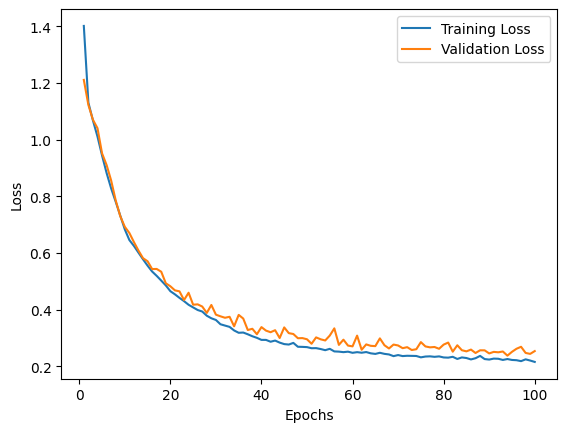

In [41]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

## Evaluate Neural Network Model

Report the model's accuracy on the test set.

In [42]:
def calculate_accuracy(model, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [43]:
accuracy = calculate_accuracy(model, test_loader)
print(f'Accuracy of the model on the test data is: {accuracy:.2f}%')

Accuracy of the model on the test data is: 90.93%


Just for the sake of curiosity, let's take a random sample from the test set and see the model's prediction. So, randomly choose a sample from the test set and print it out (to see its features and also the correct output). Then, feed the features into your model and see what it predicts. Is it correct?

In [44]:
sample = X_test.sample(n=1)
sample

,user_id,Day,hour_of_start,trip_duration,origin_label,origin_lat,origin_lon,price
4201,3,2,7,19.0,1,35.62,51.275,10.0


In [46]:
data_test.iloc[sample.index]['destination']

4201    [work, [35.625, 51.375]]
Name: destination, dtype: object

In [47]:
sample_tensor = torch.tensor(sample.values, dtype=torch.float32)
sample_tensor = sample_tensor.reshape(1, -1)
with torch.no_grad():
    output = model(sample_tensor)
    _, predicted_label = torch.max(output, 1)
predicted_label.item()

6

In [48]:
y_test.iloc[sample.index].values[0]

6

Now, use the inverse transform of the encoding you used earlier to get the name of the destination from the predicted class. Print it out and see if it's correct.

In [49]:
test_label_encoder.inverse_transform(predicted_label.numpy())[0]

'work'

**QUESTION**: What do you think about this approach? Is it a good idea to use Neural Networks for this problem? Why (or why not)? If the patterns in our datatset (passengers' history) get more complicated, will our model be robust to it in comparison to other models?

Your Answer:
***

***Using neural networks for this type of prediction problem can be effective, especially if the dataset is large and contains complex, non-linear relationships. Neural networks excel in learning intricate patterns from high-dimensional data, but they require sufficient data and computational resources. However, they might be overkill for simpler, smaller datasets and can be prone to overfitting without proper regularization.***

***Compared to KNN and XGBoost, neural networks generally handle high-dimensional, complex data better but are more resource-intensive and less interpretable. KNN is simpler and works well with smaller datasets but struggles with high dimensionality and larger datasets. XGBoost is powerful for structured/tabular data, offers good performance with less computational cost than neural networks, and is often easier to tune and interpret than deep learning models.***

***

# How to Submit:

Please upload your notebook (`.ipynb`) compressed (as a `.zip` file) or uncompressed on Quera. **Note** that for each part, the accuracy of your model on the given test dataset is important. So, your accuracy should be **at least** same as ours (or better). Also, we will check your code after the submission. So, please make sure that there are no **data snooping** or **data leakage** in your code. You **can not** use the test data in any stages for your model, except for the final evaluation part! So, please be ware of that, or you may lose points.

Your project is graded via 2 main parts: 
1. Checking out your implementation (to check if there are no "data snooping" and "data leakage") 
   
2. Checking accuracies of your models on the test set. 

3. Running again your code by you in the "in-person" session and hearing your explanations (on the parts that we asked questions about the models, overfitting and etc. with tag "QUESTION" in the notebook).